In [23]:
import os
import cv2
import math
import json
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
# Unzip dataset file
!unzip -o -q "/content/drive/MyDrive/bia_project/plant_village_dataset.zip" -d /content/

In [27]:
DATASET_PATH = "/content/plantvillage dataset/color"
random_seed = 111
IMG_SIZE = (128, 128)
BATCH_SIZE = 16


In [28]:
CHECKPOINT_PATH = "/content/drive/MyDrive/bia_project/plant_model_checkpoint.keras"
BASE_DIR = "/content/plant_data_split"
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [29]:
categories = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Class labels: ",categories,"\n\nNo. of categories = ", len(categories))

Class labels:  ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tom

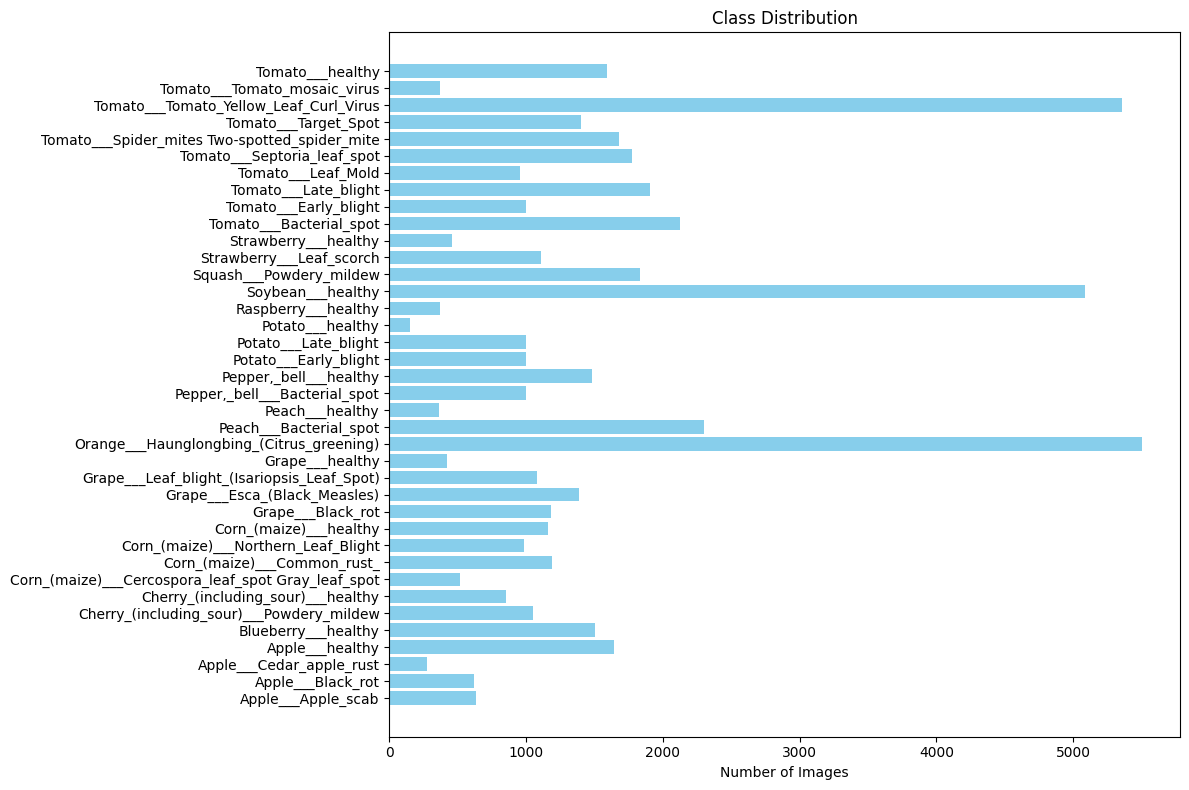

In [30]:
# Basic class counts
classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
counts = {c: len(os.listdir(os.path.join(DATASET_PATH, c))) for c in classes}

# Plot distribution
plt.figure(figsize=(12,8))
plt.barh(list(counts.keys()), list(counts.values()), color='skyblue')
ax = plt.gca()
ax.grid(False)
plt.title("Class Distribution")
plt.xlabel("Number of Images")
plt.tight_layout()
plt.show()

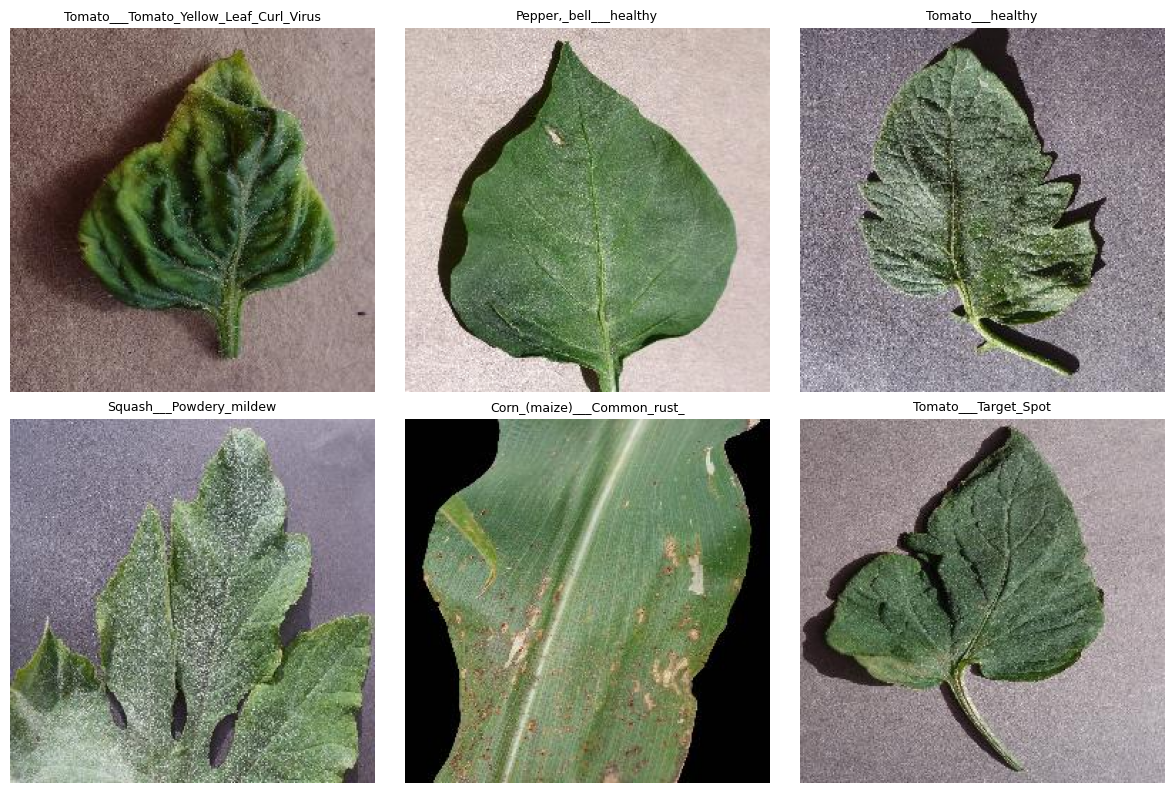

In [31]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Pick random classes
random_classes = random.sample(categories, 6)

plt.figure(figsize=(12, 8))

for i, cls in enumerate(random_classes, 1):
    class_path = os.path.join(DATASET_PATH, cls)

    # Pick a random image from the class
    img_file = random.choice([
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg'))
    ])

    img = Image.open(os.path.join(class_path, img_file))

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(cls, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [32]:
# Function for creating the directory structure
def create_split_directories():
    if os.path.exists(BASE_DIR):
        shutil.rmtree(BASE_DIR)

    for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        for category in categories:
            os.makedirs(os.path.join(d, category), exist_ok=True)

In [33]:
def split_data_to_directories(source_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Splits images from the source directory into train, val, and test subdirectories
    create_split_directories()

    for category in categories:
        cat_path = os.path.join(source_dir, category)

        # Only take up to 1000 images per category for memory simulation/control
        all_files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg'))][:1000]

        # Split data paths
        train_files, temp_files = train_test_split(all_files, test_size=(val_ratio + test_ratio), random_state=random_seed)
        val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (val_ratio + test_ratio), random_state=random_seed)

        # Move files
        for f in train_files:
            shutil.copy(os.path.join(cat_path, f), os.path.join(TRAIN_DIR, category, f))
        for f in val_files:
            shutil.copy(os.path.join(cat_path, f), os.path.join(VAL_DIR, category, f))
        for f in test_files:
            shutil.copy(os.path.join(cat_path, f), os.path.join(TEST_DIR, category, f))

    print("Data split complete.")

# Execute the file-based split
split_data_to_directories(DATASET_PATH, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)


Data split complete.


In [37]:
#Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_generator = val_test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 22368 images belonging to 38 classes.
Found 4794 images belonging to 38 classes.
Found 4800 images belonging to 38 classes.


In [38]:
# Class Weights
train_labels = train_generator.classes
unique_classes = np.unique(train_labels)
weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
class_weights = dict(enumerate(weights))

In [39]:
# Load Base Model
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), pooling='avg')

# Add Custom Head
x = base_model.output
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(categories), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [40]:
# Fine-Tuning Strategy (Unfreeze last 30 layers)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [42]:
# Check for existing checkpoint to resume
if os.path.exists(CHECKPOINT_PATH):
    print(f"Resuming from checkpoint: {CHECKPOINT_PATH}")
    model = tf.keras.models.load_model(CHECKPOINT_PATH)
else:
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Callbacks
# Save the best model automatically every epoch
checkpoint_cb = ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
# Slow down learning if model gets stuck (helps difficult classes)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

In [44]:
# Training
history = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[checkpoint_cb, reduce_lr_cb]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3459 - loss: 2.5846
Epoch 1: val_loss improved from inf to 0.62040, saving model to /content/drive/MyDrive/bia_project/plant_model_checkpoint.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 172s 100ms/step - accuracy: 0.3460 - loss: 2.5839 - val_accuracy: 0.8052 - val_loss: 0.6204 - learning_rate: 1.0000e-04
Epoch 2/12
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7798 - loss: 0.7035
Epoch 2: val_loss improved from 0.62040 to 0.34389, saving model to /content/drive/MyDrive/bia_project/plant_model_checkpoint.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 131s 93ms/step - accuracy: 0.7798 - loss: 0.7035 - val_accuracy: 0.8909 - val_loss: 0.3439 - learning_rate: 1.0000e-04
Epoch 3/12
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8437 - loss: 0.4780
Epoch 3: val_loss improved from 0.34389 to 0.26156, saving model to /content/drive/MyDrive/bia_project/plant_model_checkpoint.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 125s 89ms

In [45]:
# Evaluation
model = tf.keras.models.load_model(CHECKPOINT_PATH) # Load the best version saved
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9718 - loss: 0.0852
Test Accuracy: 96.15%


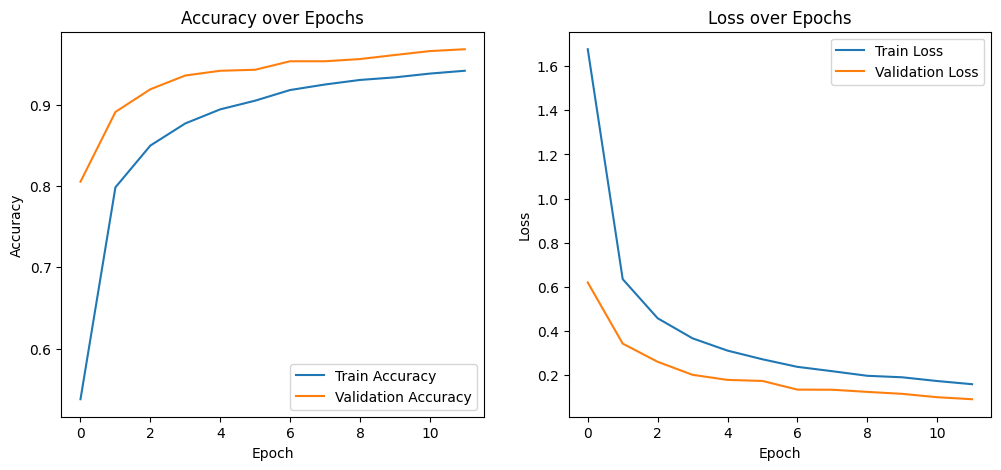

In [46]:
# Visualize training and validation history for loss and accuracy to monitor model convergence and detect overfitting.
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
# Save Model
model.save('/content/drive/MyDrive/bia_project/PlantVillageEFV2B0_Checkpoint.keras')

In [48]:
# Save class names for inference later
with open('/content/drive/MyDrive/bia_project/class_names_checkpoint.json', 'w') as f:
    json.dump(list(train_generator.class_indices.keys()), f)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/bia_project/PlantVillageEFV2B0_All_Classes.h5')

In [ ]:
# Load classes
# import json
with open('/content/drive/MyDrive/bia_project/class_names_38.json', 'r') as f:
    class_names = json.load(f)

In [51]:
# Calculate the number of steps required to cover all test images
# math.ceil ensures we get the last partial batch if the total images
# aren't perfectly divisible by the batch size
import math

test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

test_generator.reset()
Y_pred = model.predict(
    test_generator,
    steps=test_steps,
    verbose=1
)

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


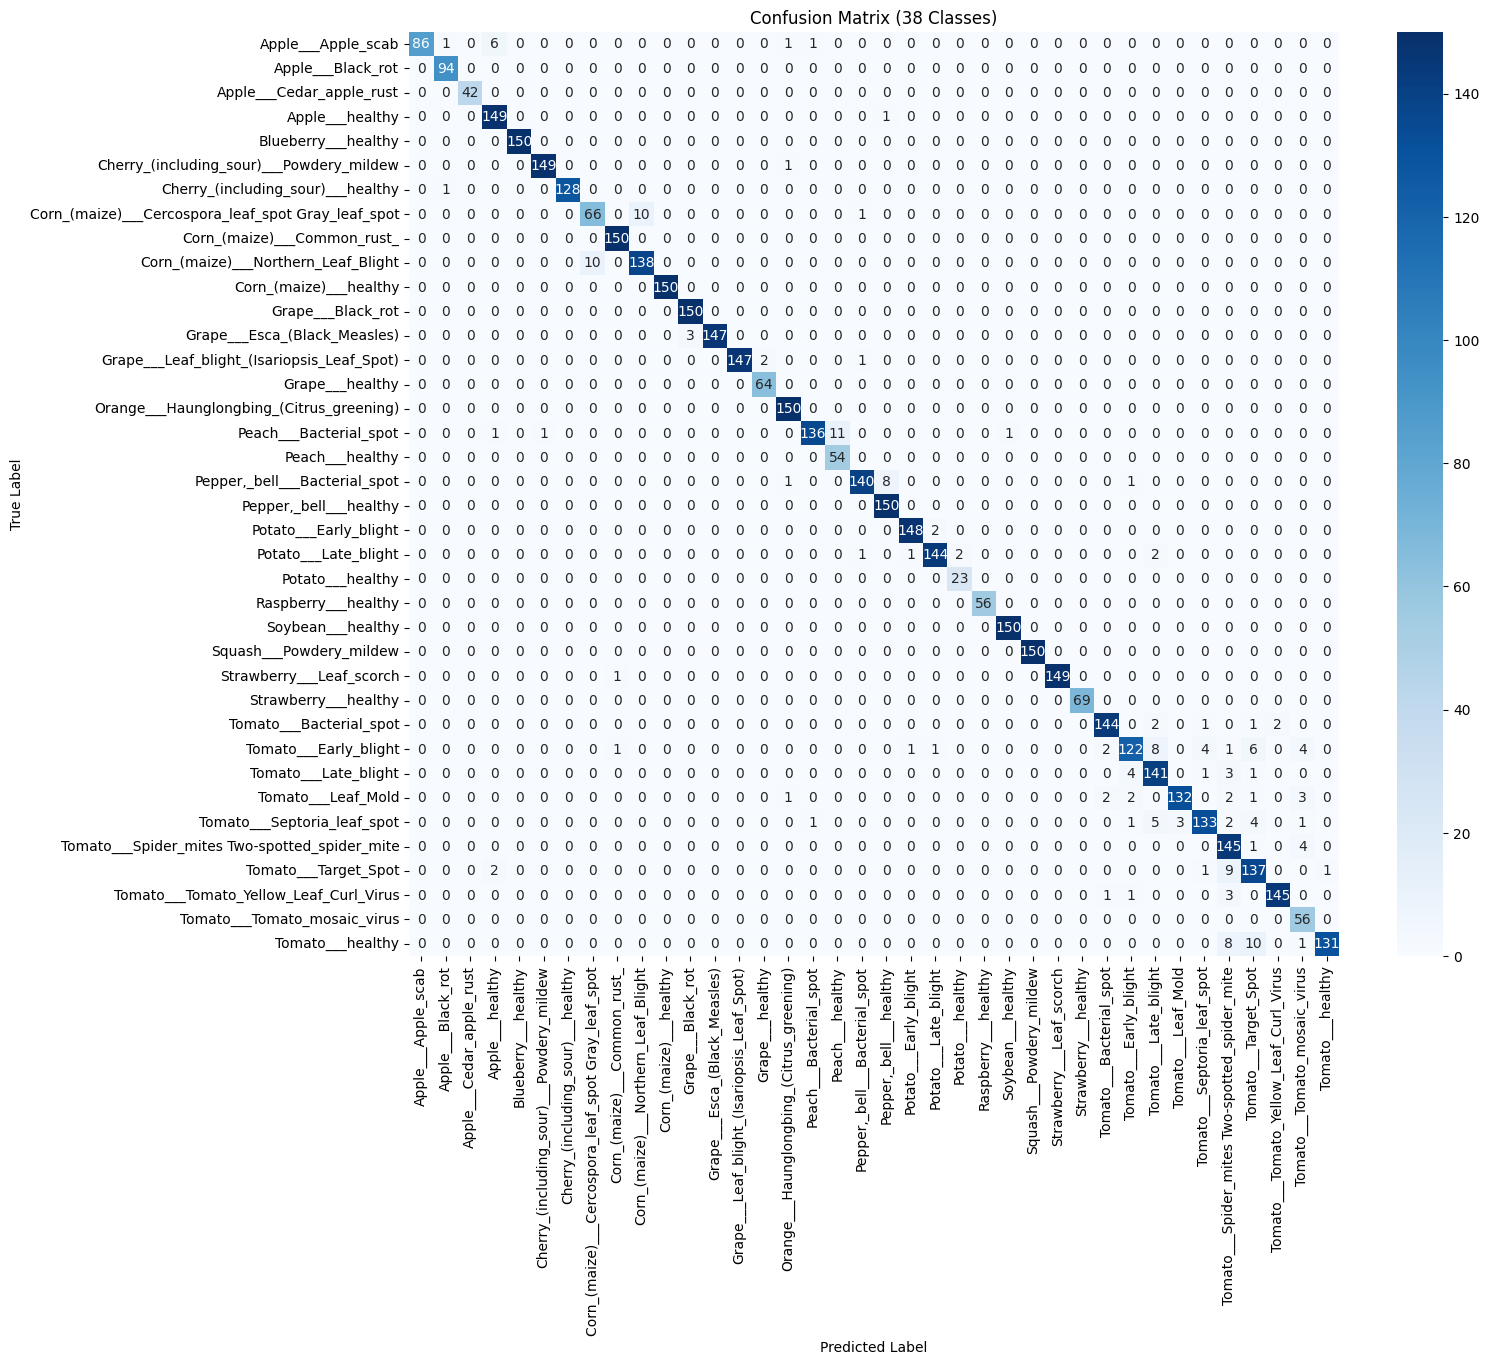

In [52]:
import math
from sklearn.metrics import confusion_matrix

# Define the missing variable
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

# 2. Predict
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = test_generator.classes

# Generate Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualization (using your existing plt code)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (38 Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [53]:
from sklearn.metrics import classification_report

# This ensures the labels match the order of the confusion matrix exactly
sorted_class_names = list(test_generator.class_indices.keys())

# Generate and Print the Classification Report
# This will show Precision, Recall, and F1-Score for all 38 classes
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=sorted_class_names,
    output_dict=False
)

print("\nCLASSIFICATION REPORT")
print(report)


CLASSIFICATION REPORT
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.91      0.95        95
                                 Apple___Black_rot       0.98      1.00      0.99        94
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        42
                                   Apple___healthy       0.94      0.99      0.97       150
                               Blueberry___healthy       1.00      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       150
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.87      0.86      0.86        77
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       150
               Corn_(maize)___Northern_Leaf_Blight      